In [7]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays

Function that returns estimate using PLUGIn

In [64]:
function PLUGIn_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
  
    #normalize the weights of the network
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
  
    z = randn(z_dim)
    iter = 1
    succ_error = 1
  
    while iter <= max_iter && succ_error > tolerance
      
      # d gives the PLUGIn direction
      d = W'*A'*(A * G(real(z)) - y)
      z -= stepsize * d
      succ_error = norm(real(stepsize * d))
      if iter % out_toggle == 0  
          println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
      end
      iter += 1
    end
    println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
  
    return z
  end

PLUGIn_CS (generic function with 1 method)

In [72]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)

    z = randn(20)
    iter = 1
    succ_error = 1
    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        d = gradient(z -> norm(y - A*G(z)), z)[1]
        z -= stepsize * d
        succ_error = norm(stepsize * d)
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    println("====> In Gradient: Iteration: $iter Successive error: $succ_error")

    return z
end

GD_CS (generic function with 1 method)

In [66]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)


z = randn(20)
m = 300; A = randn(m, 784)/sqrt(m)
y = A*G(z) + 1e-14 * randn(m)

stepsize = 2
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
z_rec = PLUGIn_CS(G,y,A, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - z_rec)
recon_error = norm(G(z) - G(z_rec))
println("recovery error: $recov_error, reconstruction error: $recon_error")

====> In quasi-gradient: Iteration: 1000 Successive error: 1.4276741050623436e-8
====> In quasi-gradient: Iteration: 1898 Successive error: 9.874047765665058e-15
recovery error: 1.2852324649281418e-12, reconstruction error: 4.027887827057692e-13


Compresed sensing with Fourier measurements

In [68]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)

x_dim = 784
z = randn(20)
sampling = rand(Bernoulli(.5), x_dim)
sampling = convert.(Int, sampling)
m = sum(sampling)
F = fft(Diagonal(sampling), 2)


nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end
F_sub = F[nnzindex,:]/sqrt(m)
print(size(F_sub), size(F))
y = F_sub*G(z) + 1e-14 * randn(m)

stepsize = 2
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000

z_rec = PLUGIn_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
recov_error = norm(z - real(z_rec))
recon_error = norm(G(z) - G(real(z_rec)))
println("recovery error: $recov_error, reconstruction error: $recon_error")






(395, 784)(784, 784)====> In quasi-gradient: Iteration: 1000 Successive error: 7.956975533787572e-9
====> In quasi-gradient: Iteration: 1758 Successive error: 9.975431009750025e-15
recovery error: 5.105176678729214e-13, reconstruction error: 1.4255733428347492e-13


Loading model...Done
====> In quasi-gradient: Iteration: 1000 Successive error: 0.0028967765082674084
====> In quasi-gradient: Iteration: 2000 Successive error: 0.0038578945012474808
====> In quasi-gradient: Iteration: 3000 Successive error: 0.0036325517424682496
====> In quasi-gradient: Iteration: 4000 Successive error: 0.00810810022450603
====> In quasi-gradient: Iteration: 5000 Successive error: 0.004420232101013491
====> In quasi-gradient: Iteration: 6000 Successive error: 0.0024095449084168444
====> In quasi-gradient: Iteration: 7000 Successive error: 0.002322631053519618
====> In quasi-gradient: Iteration: 8000 Successive error: 0.0023301058911102093
====> In quasi-gradient: Iteration: 9000 Successive error: 0.0023360992064262757
====> In quasi-gradient: Iteration: 10000 Successive error: 0.0023309773108947003
====> In quasi-gradient: Iteration: 10001 Successive error: 0.0023309773108947003
reconstruction error: 6.116086513567068
====> In Gradient: Iteration: 1000 Successive erro

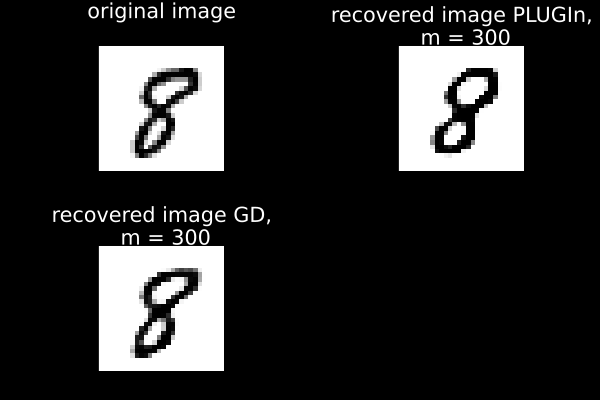

In [74]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result/MNIST", epoch_to_load)

# pick a image in MNIST to denoise
num = 8
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i]
noise_level = .1

m = 300; A = randn(m, 784)/sqrt(m)

y = A*x + noise_level * randn(m)

stepsize = 1
tolerance = 1e-7
max_iter = 10000
out_toggle = 1000
z_rec_PLUGIn = PLUGIn_CS(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)
error = norm(x - decoder(z_rec_PLUGIn))
println("reconstruction error: $error")

z_rec_GD = GD_CS(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec_PLUGIn), 28,28)' )
recovered_image_GD = colorview(Gray, reshape(decoder(z_rec_GD), 28,28)' )

true_image = colorview(Gray, reshape(x, 28,28)' );
p1 = plot(true_image, framestyle = :none, bg =:black, title = "original image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn,\n m = $m")
p3 = plot(recovered_image_GD, framestyle = :none, bg =:black, title = "recovered image GD,\n m = $m")
plot(p1, p2, p3, layout = 3)


Loading model...Done
(392, 784)(784, 784)====> In quasi-gradient: Iteration: 1000 Successive error: 0.02430139622772864
====> In quasi-gradient: Iteration: 2000 Successive error: 0.024019996535155685
====> In quasi-gradient: Iteration: 3000 Successive error: 0.023118763570012472
====> In quasi-gradient: Iteration: 4000 Successive error: 0.023383884180198242
====> In quasi-gradient: Iteration: 5000 Successive error: 0.02361164078179862
====> In quasi-gradient: Iteration: 6000 Successive error: 0.023582596158286808
====> In quasi-gradient: Iteration: 7000 Successive error: 0.023196260643805047
====> In quasi-gradient: Iteration: 8000 Successive error: 0.022740612934452342
====> In quasi-gradient: Iteration: 9000 Successive error: 0.022583215644009218
====> In quasi-gradient: Iteration: 10000 Successive error: 0.02248183045795789
====> In quasi-gradient: Iteration: 10001 Successive error: 0.02248183045795789
reconstruction error: 3.27360658628108


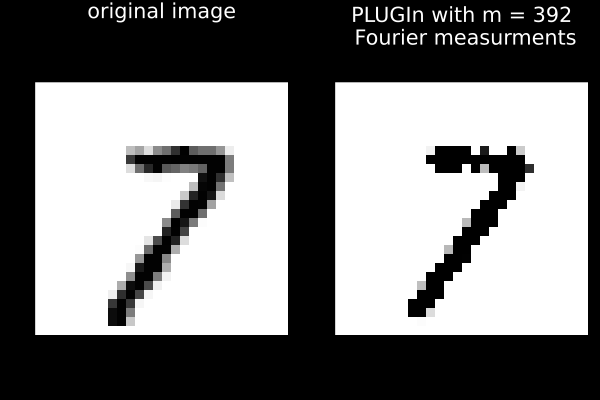

In [91]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result/MNIST", epoch_to_load)

# pick a image in MNIST to denoise
num = 7
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i]
noise_level = .1

x_dim = 784
sampling = rand(Bernoulli(.5), x_dim)
sampling = convert.(Int, sampling)
m = sum(sampling)
F = fft(Diagonal(sampling), 2)


nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end
F_sub = F[nnzindex,:]/sqrt(m)
print(size(F_sub), size(F))


y = F_sub*x + noise_level * randn(m)

stepsize = 1
tolerance = 1e-7
max_iter = 10000
out_toggle = 1000
z_rec_PLUGIn = PLUGIn_CS(decoder, y, F_sub, max_iter, stepsize, tolerance, out_toggle)
z_rec_PLUGIn = real(z_rec_PLUGIn)
error = norm(x - decoder(z_rec_PLUGIn))
println("reconstruction error: $error")

# # z_rec_GD = GD_CS(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)
recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec_PLUGIn), 28,28)' )
# # recovered_image_GD = colorview(Gray, reshape(decoder(z_rec_GD), 28,28)' )

true_image = colorview(Gray, reshape(x, 28,28)' );
p1 = plot(true_image, framestyle = :none, bg =:black, title = "original image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "PLUGIn with m = $m\n Fourier measurments")
# p3 = plot(recovered_image_GD, framestyle = :none, bg =:black, title = "recovered image GD,\n m = $m")
plot(p1, p2, layout = 2)
